In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
!pip install pytesseract


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [4]:
path = glob('/content/drive/MyDrive/input/input/number-plate-detection/annotations/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [5]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/input/input/number-plat...,134,262,128,160
1,/content/drive/MyDrive/input/input/number-plat...,226,419,125,173
2,/content/drive/MyDrive/input/input/number-plat...,141,311,113,164
3,/content/drive/MyDrive/input/input/number-plat...,66,322,147,199
4,/content/drive/MyDrive/input/input/number-plat...,167,240,202,220


In [6]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/drive/MyDrive/input/input/number-plate-detection/images',filename_image)
    return filepath_image
getFilename(filename)

'/content/drive/MyDrive/input/input/number-plate-detection/images/Cars1.png'

In [7]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['/content/drive/MyDrive/input/input/number-plate-detection/images/Cars1.png',
 '/content/drive/MyDrive/input/input/number-plate-detection/images/Cars0.png',
 '/content/drive/MyDrive/input/input/number-plate-detection/images/Cars107.png',
 '/content/drive/MyDrive/input/input/number-plate-detection/images/Cars102.png',
 '/content/drive/MyDrive/input/input/number-plate-detection/images/Cars101.png',
 '/content/drive/MyDrive/input/input/number-plate-detection/images/Cars103.png',
 '/content/drive/MyDrive/input/input/number-plate-detection/images/Cars100.png',
 '/content/drive/MyDrive/input/input/number-plate-detection/images/Cars104.png',
 '/content/drive/MyDrive/input/input/number-plate-detection/images/Cars106.png',
 '/content/drive/MyDrive/input/input/number-plate-detection/images/Cars10.png']


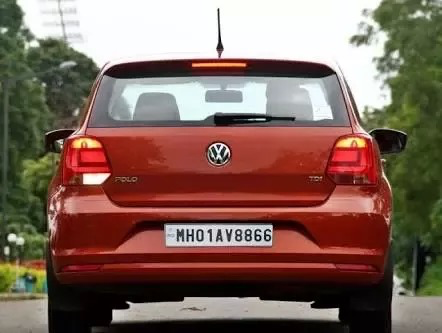

In [8]:
file_path = image_path[95] #path of our image N2.jpeg
img = cv2.imread(file_path)
# <xmin>164</xmin>
# <ymin>224</ymin>
# <xmax>272</xmax>
# <ymax>247</ymax>
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - sample image with bounding box')
fig.add_shape(type='rect',x0=164, x1=272 ,y0=224, y1=247, xref='x', yref='y',line_color='cyan')

In [9]:
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [10]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [11]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((346, 224, 224, 3), (87, 224, 224, 3), (346, 4), (87, 4))

In [12]:

inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 1s 0us/step


In [13]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [58]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=150,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/150
35/35 [==============================] - 118s 356ms/step - loss: 6.2688e-04 - val_loss: 0.0175
Epoch 2/150
35/35 [==============================] - 9s 250ms/step - loss: 5.0788e-04 - val_loss: 0.0171
Epoch 3/150
35/35 [==============================] - 9s 244ms/step - loss: 6.4168e-04 - val_loss: 0.0172
Epoch 4/150
35/35 [==============================] - 9s 245ms/step - loss: 5.9140e-04 - val_loss: 0.0169
Epoch 5/150
35/35 [==============================] - 8s 243ms/step - loss: 5.7578e-04 - val_loss: 0.0172
Epoch 6/150
35/35 [==============================] - 8s 239ms/step - loss: 6.2529e-04 - val_loss: 0.0175
Epoch 7/150
35/35 [==============================] - 8s 242ms/step - loss: 5.9771e-04 - val_loss: 0.0169
Epoch 8/150
35/35 [==============================] - 8s 240ms/step - loss: 4.9639e-04 - val_loss: 0.0177
Epoch 9/150
35/35 [==============================] - 8s 240ms/step - loss: 4.9351e-04 - val_loss: 0.0147
Epoch 10/150
35/35 [==============================] -

In [59]:
model.save('./numberplate_detection.h5')

In [60]:
# Load model
model = tf.keras.models.load_model('./numberplate_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [74]:
path = '/content/drive/MyDrive/input/input/number-plate-detection/TEST/np.jpg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 570
Width of the image = 870



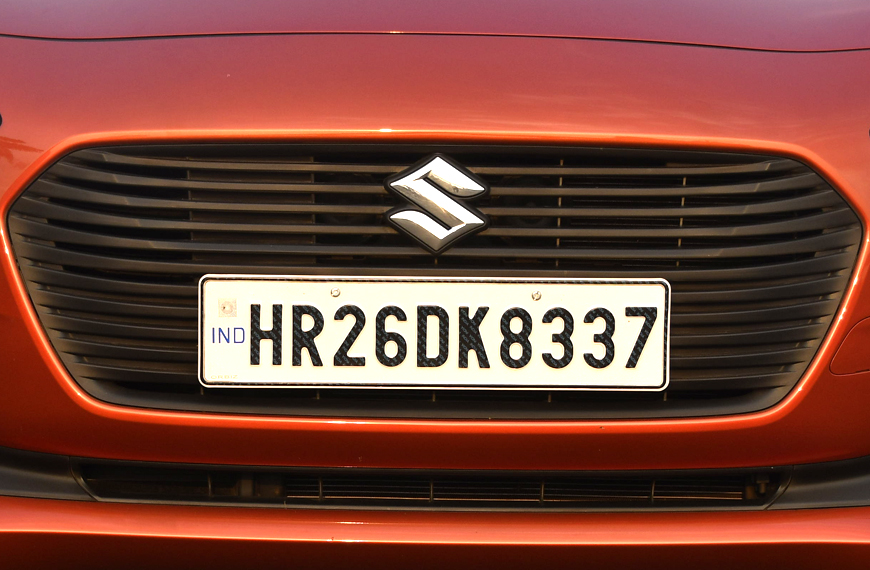

In [75]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

In [76]:
image_arr_224.shape

(224, 224, 3)

In [77]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [78]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 0s 76ms/step


array([[0.27920172, 0.7210187 , 0.45721337, 0.6836584 ]], dtype=float32)

In [79]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[242.90549308, 627.28624463, 260.61162204, 389.68529999]])

In [80]:
coords = coords.astype(np.int32)
coords

array([[242, 627, 260, 389]], dtype=int32)

In [81]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(242, 260) (627, 389)



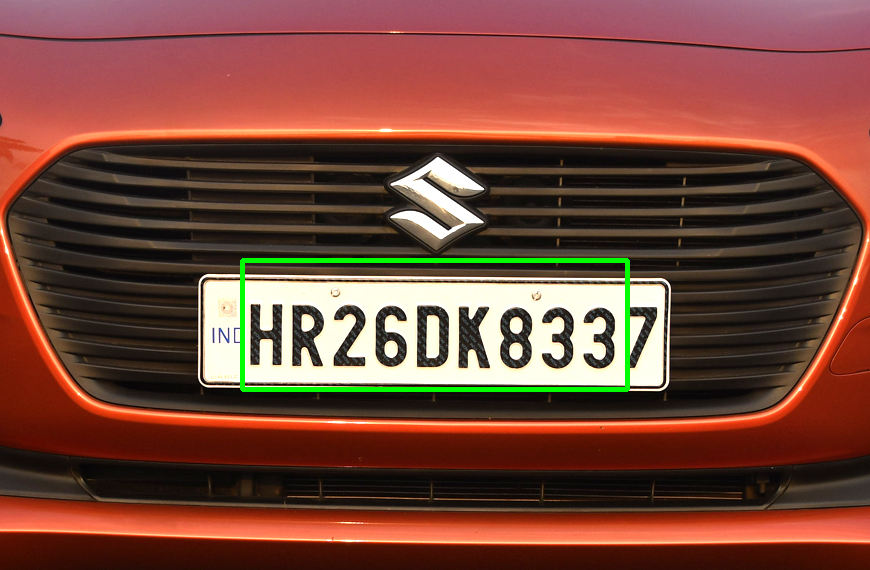

In [82]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

1/1 [==============================] - 0s 44ms/step
(411, 276) (715, 378)



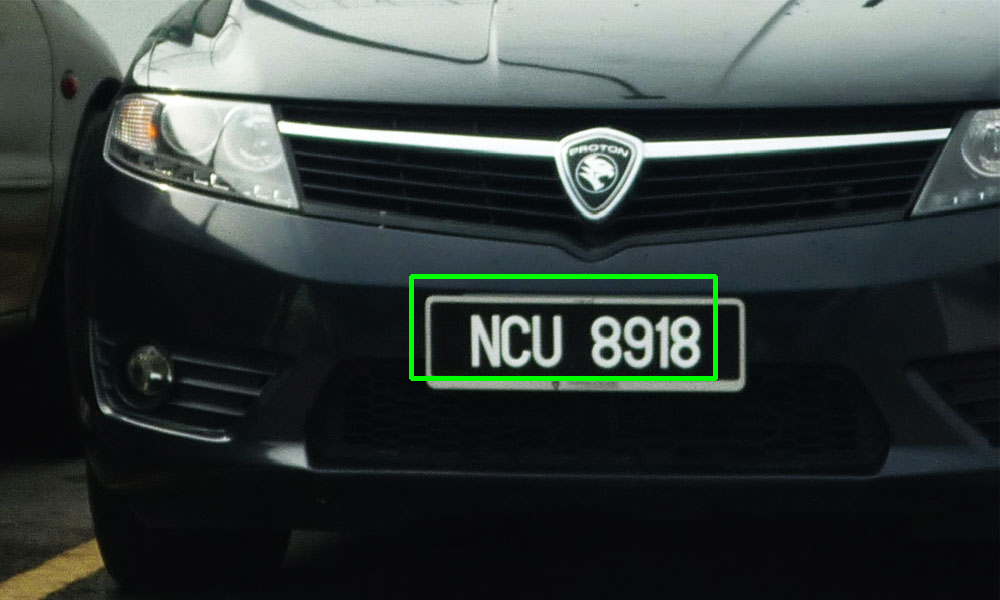

In [87]:
# Create pipeline
path = '/content/drive/MyDrive/input/input/number-plate-detection/TEST/np5.jpg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')


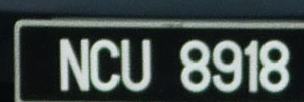

In [88]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure  Cropped image')

In [30]:
!apt-get install tesseract-ocr-eng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 46 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 0s (11.9 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 122541 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3a4.00

In [33]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 19.0 MB/s eta 0:00:00


In [89]:
# # # extract text from image
# text = pt.image_to_string(roi)
# print(text)

import easyocr
reader=easyocr.Reader(['en'])
result=reader.readtext(roi)


In [90]:
result

[([[50, 30], [302, 30], [302, 102], [50, 102]],
  'NCU 8918',
  0.7302523848579436)]